In [67]:
import spimage
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

## Choose a run

In [10]:
run = 14

In [11]:
path_to_preproc = "/Users/benedikt/data/LCLS/amol3416/sucrose/"

In [12]:
preproc_fname = path_to_preproc + "amol3416_r%04d_ol3.h5" %run

## Read/define parameters

In [13]:
with h5py.File(preproc_fname, "r") as f:
    nframes,ny,nx = f['entry_1/data_1/data'].shape
    gain = f['entry_1/detector_1/gain'][:]
    wavelength_nm = f['entry_1/FEL/wavelength_nm_SLAC'][:]
    photon_energy_ev = f['entry_1/FEL/photon_energy_eV_SLAC'][:]
    mask_initial = ~f['entry_1/detector_1/mask'][:].astype(np.bool)

In [14]:
# Shape of detector                                                                                       
sh = (ny,nx)

In [15]:
# Preprocessing parameters                                                                                
saturation_level = 10000
downsampling = 4

In [16]:
# Experimental parameters                                                                                 
pixelsize  = downsampling * 75e-6 #[m]                                                                    
distance   = 370 * 1e-3
material   = "sucrose"
wavelength = wavelength_nm * 1e-9

In [17]:
# Centering parameters                                                                                    
centering_maxshift  = 30 / downsampling
centering_threshold = 0.5
centering_blur      = 4
centering_x0 = sh[1]/2.
centering_y0 = sh[0]/2.

In [18]:
# Sizing parameters                                                                                       
diameter_start  = 55 * 1e-9
intensity_start = 1. * 1e-3 / 1e-12 #[mJ/um2]                                                             
brute_evals = 100
rmax = 500 / downsampling
maskradius = 100 / downsampling

In [19]:
# Spherical mask                                                                                          
def rmask(r, sh, cx, cy):
    ny, nx = sh
    xx,yy = np.meshgrid(np.arange(nx), np.arange(ny))
    return (xx-cx)**2 + (yy-cy)**2 > (r**2)

## Read single shot data

In [50]:
index = 8

In [51]:
# Read in data                                                                                        
with h5py.File(preproc_fname, 'r') as f:
    data = np.float64(f['entry_1/data_1/data'][index])

## Prepare for size/fluence estimation

In [52]:
# Mask out saturated pixels                                                                           
mask_saturated = (data < saturation_level)
mask = mask_initial & mask_saturated

# Throw away background                                                                               
data[data <= centering_threshold*gain[index]] = 0.

# Gain calibration                                                                                    
data_c = data / gain[index]

# Downsampling                                                                                        
data_ds, mask_ds = spimage.binImage(data_c, downsampling, msk=mask, output_binned_mask=True)

# Photon counting                                                                                     
photons = np.round(data_ds)
mask = mask_ds.astype(np.bool)

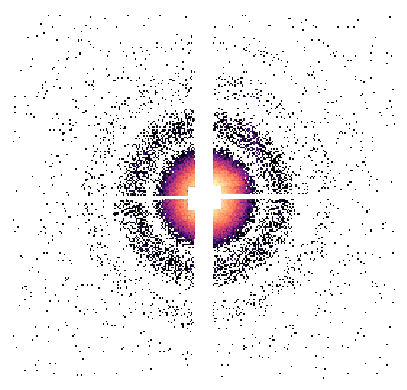

In [53]:
plt.figure(figsize=(5,5), dpi=100)
plt.axis('off')
plt.imshow(photons*mask, norm=colors.LogNorm(), cmap='magma')
plt.show()

## Find center of diffraction

In [54]:
# Step 1: Finding the center                                                                          
x,y = spimage.find_center(photons,mask,method='blurred',
                          x0=centering_x0, y0=centering_y0,dmax=centering_maxshift,
                          threshold=centering_threshold, blur_radius=centering_blur)
print("Step 1: Found center position (%.2f, %2.f)" %(x,y))

Step 1: Found center position (3.50,  2)


In [55]:
# Add spherical mask in the center                                                                    
mask &= rmask(maskradius, mask.shape, mask.shape[1]/2+x, mask.shape[0]/2+y)

## Get initial size estimate

In [57]:
# Step 2: Finding the size                                                                            
diameter, info = spimage.fit_sphere_diameter(photons, mask, diameter_start, intensity_start,
                                             wavelength[index], pixelsize, distance,
                                             method='pearson', full_output=True, x0=x, y0=y,
                                             detector_adu_photon=1., detector_quantum_efficiency=1.,
                                             material=material, rmax=rmax, downsampling=1,
                                             do_brute_evals=brute_evals, do_photon_counting=False,
                                             maxfev=50000, brute_dmax=200e-9)

print("Step 2: Found diameter of %.2f nm" %(diameter*1e9))
print("Chisquared/Norm. Mean Error: %.3g/%.3g" %(info["chisquared"], info['error']))

Step 2: Found diameter of 49.93 nm
Chisquared/Norm. Mean Error: 2.23e-07/1.44e-10


## Get initial fluence estimate

In [58]:
# Step 3: Finding the intensity                                                                       
intensity, info = spimage.fit_sphere_intensity(photons, mask, diameter, intensity_start,
                                               wavelength[index], pixelsize, distance,
                                               method='nrphotons', full_output=True, x0=x, y0=y,
                                               detector_adu_photon=1., detector_quantum_efficiency=1.,
                                               material=material, rmax=rmax, downsampling=1, do_photon_counting=True)
print("Step 3: Found intensity of %.4f mJ/um2" %(intensity / (1e-3 / 1e-12)))
print("Chisquared/Norm. Mean Error: %.3g/%.3g" %(info["chisquared"], info['error']))

Step 3: Found intensity of 0.0033 mJ/um2
Chisquared/Norm. Mean Error: 0/0


## Get final size/fluence estimate

In [59]:
# Step 4: Full optimization                                                                           
x, y, diameter, intensity, info = spimage.fit_full_sphere_model(photons, mask, diameter, intensity,
                                                                wavelength[index], pixelsize, distance,
                                                                full_output=True, x0=x, y0=y,
                                                                detector_adu_photon=1., detector_quantum_efficiency=1.,
                                                                material=material, rmax=rmax,
                                                                downsampling=1, do_photon_counting=True, deltab=0.5, n=1)
print("Step 4: Full optimization (x=%.2f, y=%.3f, d=%.3f nm, i=%.4f mJ/um2)" %(x,y, diameter*1e9, intensity / (1e-3 / 1e-12)))
print("Chisquared/Norm. Mean Error: %.3g/%.3g" %(info["chisquared"], info['error']))

Step 4: Full optimization (x=2.22, y=2.059, d=49.934 nm, i=0.0031 mJ/um2)
Chisquared/Norm. Mean Error: 0.215/1.04e-05


## Calculate radial average

In [61]:
nxnew = (nx - nx % downsampling) // downsampling
nynew = (ny - ny % downsampling) // downsampling
centers, photons_r = spimage.radialMeanImage(photons, msk=mask,
                                             cx=photons.shape[1]/2+x, cy=photons.shape[0]/2+y, output_r=True)
photons_qr = spimage.x_to_qx(centers, pixelsize, distance)[:max(nxnew, nynew)]
photons_r  = photons_r[:max(nxnew, nynew)]

## Calculate fitted image/radial average

In [62]:
Y,X = spimage.grid(photons.shape, (0,0))
Xc = spimage.x_to_qx(X - x,pixelsize,distance)
Yc = spimage.y_to_qy(Y - y,pixelsize,distance)
q = np.sqrt(Xc**2 + Yc**2)
qr = spimage.x_to_qx(np.arange(0,photons.shape[0]/2.), pixelsize/downsampling, distance)

In [65]:
A = spimage.sphere_model_convert_intensity_to_scaling(intensity, diameter, wavelength[index], pixelsize, 
                                                      distance, material=material)
s = spimage.sphere_model_convert_diameter_to_size(diameter, wavelength[index], pixelsize, distance)
fit_2d = np.random.poisson(spimage.I_sphere_diffraction(A,q,s)).astype(np.float64)
fit_1d = spimage.I_sphere_diffraction(A,qr,s)

## Plotting the fitted results

In [68]:
cmap = cm.get_cmap('magma')
cmap.set_bad('green')
cmap.set_under('black')

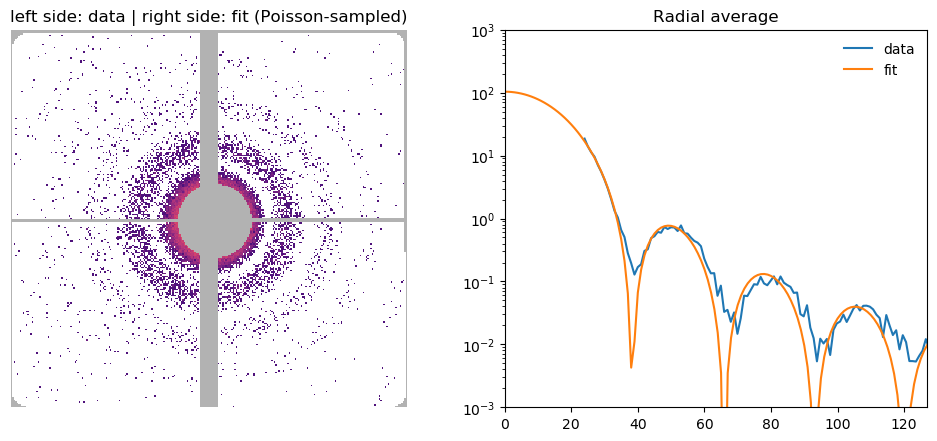

In [80]:
img = np.copy(photons)
img[:,photons.shape[1]//2:] = fit_2d[:,photons.shape[1]//2:]
img[img == 0] = 1e-10
img[~mask] = np.nan
cmap.set_bad('0.7')
cmap.set_under('white')
fig, axes = plt.subplots(ncols=2, figsize=(12,5), dpi=100)
axes[0].axis('off')
axes[0].set_title('left side: data | right side: fit (Poisson-sampled)')
axes[0].imshow(img*mask, norm=colors.LogNorm(vmin=0.1, vmax=1000), cmap=cmap)
axes[1].set_title("Radial average")
axes[1].plot(photons_qr, photons_r, label='data')
axes[1].plot(qr, fit_1d, label='fit')
axes[1].set_ylim(1e-3,1e3)
axes[1].set_xlim(0,qr.max())
axes[1].semilogy()
axes[1].legend(frameon=False)
plt.show()